<a href="https://colab.research.google.com/github/mobarakol/AI_Medical_Imaging/blob/main/SHAP_IMAGE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 7.2 MB/s eta 0:00:00


Preparing Model on ImageNet Pretrained Weights:


In [2]:
import json

import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt

import shap

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = torchvision.models.mobilenet_v2(pretrained=True, progress=False)
model.to(device)
model.eval()
X, y = shap.datasets.imagenet50()
print('number of images:', X.shape)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


number of images: (50, 224, 224, 3)


Preparing Data

Number of ImageNet classes: 1000


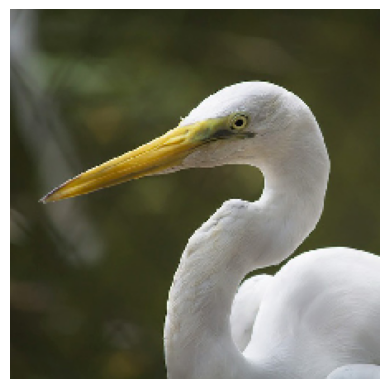

In [ ]:
# Getting ImageNet 1000 class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
with open(shap.datasets.cache(url)) as file:
    class_names = [v[1] for v in json.load(file).values()]
print("Number of ImageNet classes:", len(class_names))

# Prepare data transformation pipeline

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


def nhwc_to_nchw(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[1] == 3 else x.permute(0, 3, 1, 2)
    elif x.dim() == 3:
        x = x if x.shape[0] == 3 else x.permute(2, 0, 1)
    return x


def nchw_to_nhwc(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[3] == 3 else x.permute(0, 2, 3, 1)
    elif x.dim() == 3:
        x = x if x.shape[2] == 3 else x.permute(1, 2, 0)
    return x


transform = [
    torchvision.transforms.Lambda(nhwc_to_nchw),
    torchvision.transforms.Lambda(lambda x: x * (1 / 255)),
    torchvision.transforms.Normalize(mean=mean, std=std),
    torchvision.transforms.Lambda(nchw_to_nhwc),
]

inv_transform = [
    torchvision.transforms.Lambda(nhwc_to_nchw),
    torchvision.transforms.Normalize(
        mean=(-1 * np.array(mean) / np.array(std)).tolist(),
        std=(1 / np.array(std)).tolist(),
    ),
    torchvision.transforms.Lambda(nchw_to_nhwc),
]

transform = torchvision.transforms.Compose(transform)
inv_transform = torchvision.transforms.Compose(inv_transform)

Xtr = transform(torch.Tensor(X))
img = inv_transform(Xtr).cpu().numpy()[1]
plt.imshow(img)
plt.axis('OFF');

Prediction:

In [ ]:
def predict(img: np.ndarray) -> torch.Tensor:
    img = nhwc_to_nchw(torch.Tensor(img))
    img = img.to(device)
    output = model(img)
    return output

# Check that transformations work correctly
Xtr = transform(torch.Tensor(X))
out = predict(Xtr[1:3])
classes = torch.argmax(out, axis=1).cpu().numpy()
print(f"Classes: {classes}: {np.array(class_names)[classes]}")

Classes: [132 814]: ['American_egret' 'speedboat']


Explain the prediction with SHAP

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [05:38, 338.50s/it]              


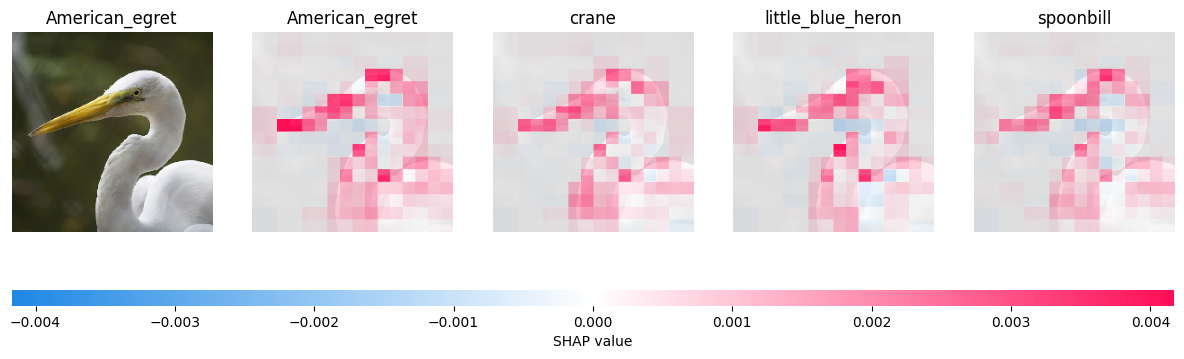

In [ ]:
topk = 4
batch_size = 50
n_evals = 10000

# define a masker that is used to mask out partitions of the input image.
masker_blur = shap.maskers.Image("blur(128,128)", Xtr[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(predict, masker_blur, output_names=class_names)

# feed only one image
# here we explain two images using 100 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(
    Xtr[1:2],
    max_evals=n_evals,
    batch_size=batch_size,
    outputs=shap.Explanation.argsort.flip[:topk],
)

shap_values.data = inv_transform(shap_values.data).cpu().numpy()[0]
shap_values.values = [val for val in np.moveaxis(shap_values.values[0], -1, 0)]

shap.image_plot(
    shap_values=shap_values.values,
    pixel_values=shap_values.data,
    labels=shap_values.output_names,
    true_labels=[class_names[132]],
)

# SHAP on Brain Tumor Dataset
source: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset<br>
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']<br>
number of training MRIs slices = 5712 <br>
number of testing MRIs slices = 1311 <br>

Download the dataset:

In [2]:
import gdown

url = 'https://drive.google.com/uc?id=1Oms9X0Vpid_kN8jiSgz-3MhRA5BcmivE'
gdown.download(url,'braintumor.zip',quiet=True)
!unzip -q braintumor.zip -d braintumor

Download my trained weights on resnet34:

In [3]:
import gdown

!mkdir myweights
url = 'https://drive.google.com/uc?id=19GYVgCz9wjO4wdCmFWhUw9_Uylzylfqe'
gdown.download(url,'myweights/best_model.pth.tar',quiet=True)

'myweights/best_model.pth.tar'

Data preprocessing as training model

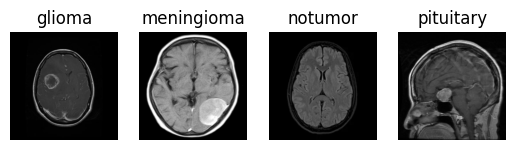

In [4]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from PIL import Image

# Prepare data transformation pipeline

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


def nhwc_to_nchw(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[1] == 3 else x.permute(0, 3, 1, 2)
    elif x.dim() == 3:
        x = x if x.shape[0] == 3 else x.permute(2, 0, 1)
    return x


def nchw_to_nhwc(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[3] == 3 else x.permute(0, 2, 3, 1)
    elif x.dim() == 3:
        x = x if x.shape[2] == 3 else x.permute(1, 2, 0)
    return x


transform = [
    torchvision.transforms.Lambda(nhwc_to_nchw),
    torchvision.transforms.Lambda(lambda x: x * (1 / 255)),
    torchvision.transforms.Normalize(mean=mean, std=std),
    torchvision.transforms.Lambda(nchw_to_nhwc),
]

inv_transform = [
    torchvision.transforms.Lambda(nhwc_to_nchw),
    torchvision.transforms.Normalize(
        mean=(-1 * np.array(mean) / np.array(std)).tolist(),
        std=(1 / np.array(std)).tolist(),
    ),
    torchvision.transforms.Lambda(nchw_to_nhwc),
]

transform = torchvision.transforms.Compose(transform)
inv_transform = torchvision.transforms.Compose(inv_transform)
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

newsize = (224, 224)
img_glioma = Image.open('/content/braintumor/Testing/glioma/Te-gl_0014.jpg').resize(newsize)
img_meningioma = Image.open('/content/braintumor/Testing/meningioma/Te-me_0017.jpg').resize(newsize)
img_healthy = Image.open('/content/braintumor/Testing/notumor/Te-noTr_0002.jpg').resize(newsize)
img_pituitary = Image.open('/content/braintumor/Testing/pituitary/Te-piTr_0008.jpg').resize(newsize)
plt.subplot(1,4,1), plt.axis('OFF'), plt.title(class_names[0]), plt.imshow(img_glioma)
plt.subplot(1,4,2), plt.axis('OFF'),plt.title(class_names[1]), plt.imshow(img_meningioma)
plt.subplot(1,4,3), plt.axis('OFF'),plt.title(class_names[2]), plt.imshow(img_healthy)
plt.subplot(1,4,4), plt.axis('OFF'),plt.title(class_names[3]), plt.imshow(img_pituitary);


Model Prediction:

In [5]:
import torch
from torchvision import models

device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_classes = 4

def tumor_prediction(img):
    model = models.resnet34()
    model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    model.to(device)
    model.load_state_dict(torch.load('/content/myweights/best_model.pth.tar', map_location=device))
    model.eval()
    img = transform(torch.Tensor(np.array(img)))
    img = nhwc_to_nchw(torch.Tensor(img)).unsqueeze(0).to(device)
    logit = model(img)
    predicted_classes = torch.argmax(logit, axis=1).cpu().numpy()
    return predicted_classes

with torch.no_grad():
    predicted_classes = tumor_prediction(img_glioma)
    print('Predicted Class:', class_names[predicted_classes[0]])


Predicted Class: glioma


Applying SHAP

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 69.7MB/s]


  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:41, 41.35s/it]               


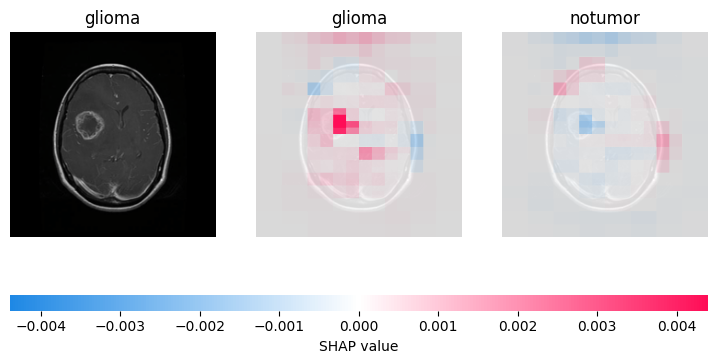

In [6]:
import numpy as np
import torch
import torchvision
from torchvision import models
import matplotlib.pyplot as plt
import shap
import matplotlib.pyplot as plt
from PIL import Image

def load_model():
    model = models.resnet34(pretrained=True)
    model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    model.to(device)
    model.load_state_dict(torch.load('/content/myweights/best_model.pth.tar', map_location=device))
    model.eval()
    return model

def predict(img: np.ndarray) -> torch.Tensor:
    img = nhwc_to_nchw(torch.Tensor(img))
    img = img.to(device)
    output = model(img)
    return output

device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_classes = 4
topk = 2
batch_size = 50
n_evals = 10000
model = load_model()

img = transform(torch.Tensor(np.array(img_glioma))).unsqueeze(0)

# define a masker that is used to mask out partitions of the input image.
masker_blur = shap.maskers.Image("blur(128,128)", img[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(predict, masker_blur, output_names=class_names)

# feed only one image
# here we explain two images using 100 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(
    img,
    max_evals=n_evals,
    batch_size=batch_size,
    outputs=shap.Explanation.argsort.flip[:topk],
)

shap_values.data = inv_transform(shap_values.data).cpu().numpy()[0]
shap_values.values = [val for val in np.moveaxis(shap_values.values[0], -1, 0)]

shap.image_plot(
    shap_values=shap_values.values,
    pixel_values=shap_values.data,
    labels=shap_values.output_names,
    true_labels=[class_names[0]],
)